#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import sys
import gzip
import idx2numpy
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


np.random.seed(42)
dir_path = os.path.dirname(
    os.path.realpath(os.path.join(os.getcwd()))
)

#### Reading train, test data

In [2]:
with gzip.open(dir_path+"\\data\\fashion_mnist\\train-images-idx3-ubyte.gz", 'rb') as f:
    train_data = idx2numpy.convert_from_file(f)

with gzip.open(dir_path+"\\data\\fashion_mnist\\train-labels-idx1-ubyte.gz", 'rb') as f:
    train_labels = idx2numpy.convert_from_file(f)

In [3]:
with gzip.open(dir_path+"\\data\\fashion_mnist\\t10k-images-idx3-ubyte.gz", 'rb') as f:
    test_data = idx2numpy.convert_from_file(f)

with gzip.open(dir_path+"\\data\\fashion_mnist\\t10k-labels-idx1-ubyte.gz", 'rb') as f:
    test_labels = idx2numpy.convert_from_file(f)

In [4]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

#### Dataset charectiristics

In [5]:
pd.Series(train_labels).nunique(), pd.Series(test_labels).nunique()

(10, 10)

In [6]:
print('Train data labels distribution: ')
pd.Series(train_labels).value_counts()

Train data labels distribution: 


9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

In [7]:
print('Test data labels distribution: ')
pd.Series(test_labels).value_counts()

Test data labels distribution: 


9    1000
2    1000
1    1000
6    1000
4    1000
5    1000
7    1000
3    1000
8    1000
0    1000
dtype: int64

In [9]:
fashion_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

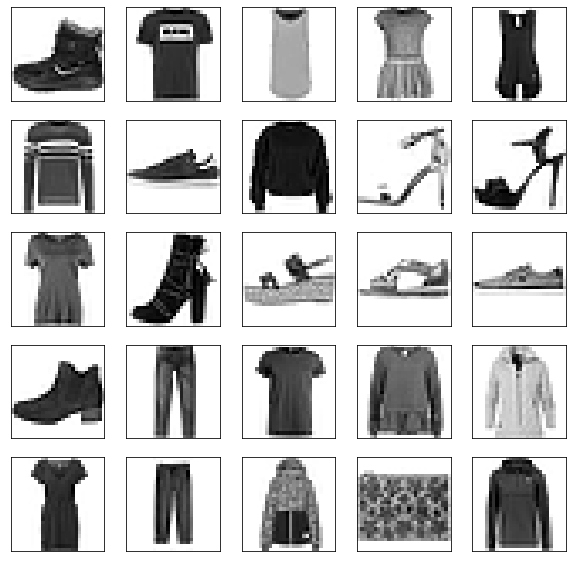

In [10]:
def view_samples():
    plt.figure(figsize=(10, 10))
    for index in range(25):
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_data[index].squeeze(), cmap=plt.cm.binary)
        plt.xlabel(f"{fashion_dict[train_labels[index].item()]}, {train_labels[index]}", color='white')
    plt.show()


view_samples()

#### Data preprocessing

In [11]:
class TrainingSet(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.target[index]
        image = self.data[index].astype("float32").reshape((28, 28, 1))
        if self.transform:
            image = self.transform(image)
        return image, label


class TestSet(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.target[index]
        image = self.data[index].astype("float32").reshape((28, 28, 1))
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
train_labels = pd.Series(train_labels)
test_labels = pd.Series(test_labels)

In [13]:
training_data = TrainingSet(
    data=train_data, target=train_labels, transform=transforms.ToTensor()
)

test_data = TestSet(
    data=test_data, target=test_labels, transform=transforms.ToTensor()
)

In [14]:
total_train = len(training_data)
train_size = int(0.8 * total_train)
val_size = total_train - train_size  # This ensures all data is used

# Split the data
train_data, val_data = random_split(training_data, [train_size, val_size])

In [15]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")
for X, y in train_loader:
    print("Training batch - X shape:", X.shape, "Y shape:", y.shape)
    break  

for X, y in val_loader:
    print("Validation batch - X shape:", X.shape, "Y shape:", y.shape)
    break  

for X, y in test_loader:
    print("Testing batch - X shape:", X.shape, "Y shape:", y.shape)
    break  

Training batches: 750
Validation batches: 188
Testing batches: 157
Training batch - X shape: torch.Size([64, 1, 28, 28]) Y shape: torch.Size([64])
Validation batch - X shape: torch.Size([64, 1, 28, 28]) Y shape: torch.Size([64])
Testing batch - X shape: torch.Size([64, 1, 28, 28]) Y shape: torch.Size([64])


#### Model training utils

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
class CNN(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # 26 x 26 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3),  # 24 x 24 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 12 x 12 x 32
            nn.Conv2d(32, 64, kernel_size=3),  # 10 x 10 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3),  # 8 x 8 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4 x 4 x 64
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(512, num_labels),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model = CNN(num_labels=len(fashion_dict))
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.long().to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(
        f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n"
    )
    return average_train_loss, train_accuracy

In [19]:
def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.long().to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(
        f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n"
    )
    return average_val_loss, val_accuracy

In [20]:
def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.float().to(device), y.long().to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy

#### Model training process

In [21]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []
epochs = 10
max_acc = 0
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if max_acc < val_acc:
        print(
            f"[SAVING] Validation Accuracy Increased({(100*max_acc):>0.1f}% ---> {(100*val_acc):>0.1f}%)"
        )
        max_acc = val_acc

        # Saving State Dict
        torch.save(model.state_dict(), dir_path+"\\model\\saved_model.pth")
print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 2.456516  [   64/48000]
loss: 0.398713  [ 6464/48000]
loss: 0.304454  [12864/48000]
loss: 0.311390  [19264/48000]
loss: 0.429273  [25664/48000]
loss: 0.342432  [32064/48000]
loss: 0.314414  [38464/48000]
loss: 0.131738  [44864/48000]
Training Error: 
 Accuracy: 86.7%, Avg loss: 0.363903 



 10%|█         | 1/10 [02:05<18:45, 125.01s/it]

Validation Error: 
 Accuracy: 89.2%, Validation loss: 0.292895 

[SAVING] Validation Accuracy Increased(0.0% ---> 89.2%)
Epoch 2
-------------------------------
loss: 0.242302  [   64/48000]
loss: 0.211730  [ 6464/48000]
loss: 0.270306  [12864/48000]
loss: 0.391188  [19264/48000]
loss: 0.201814  [25664/48000]
loss: 0.237328  [32064/48000]
loss: 0.233152  [38464/48000]
loss: 0.252551  [44864/48000]
Training Error: 
 Accuracy: 91.5%, Avg loss: 0.234440 



 20%|██        | 2/10 [03:54<15:28, 116.12s/it]

Validation Error: 
 Accuracy: 90.5%, Validation loss: 0.260063 

[SAVING] Validation Accuracy Increased(89.2% ---> 90.5%)
Epoch 3
-------------------------------
loss: 0.162852  [   64/48000]
loss: 0.214493  [ 6464/48000]
loss: 0.333463  [12864/48000]
loss: 0.064053  [19264/48000]
loss: 0.304916  [25664/48000]
loss: 0.063362  [32064/48000]
loss: 0.204507  [38464/48000]
loss: 0.243622  [44864/48000]
Training Error: 
 Accuracy: 92.9%, Avg loss: 0.194924 



 30%|███       | 3/10 [05:43<13:07, 112.56s/it]

Validation Error: 
 Accuracy: 90.8%, Validation loss: 0.256046 

[SAVING] Validation Accuracy Increased(90.5% ---> 90.8%)
Epoch 4
-------------------------------
loss: 0.315464  [   64/48000]
loss: 0.153313  [ 6464/48000]
loss: 0.152359  [12864/48000]
loss: 0.259942  [19264/48000]
loss: 0.067108  [25664/48000]
loss: 0.112900  [32064/48000]
loss: 0.165323  [38464/48000]
loss: 0.107389  [44864/48000]
Training Error: 
 Accuracy: 94.1%, Avg loss: 0.159609 



 40%|████      | 4/10 [07:37<11:19, 113.29s/it]

Validation Error: 
 Accuracy: 91.4%, Validation loss: 0.248459 

[SAVING] Validation Accuracy Increased(90.8% ---> 91.4%)
Epoch 5
-------------------------------
loss: 0.072927  [   64/48000]
loss: 0.102754  [ 6464/48000]
loss: 0.155074  [12864/48000]
loss: 0.085294  [19264/48000]
loss: 0.121253  [25664/48000]
loss: 0.030169  [32064/48000]
loss: 0.073490  [38464/48000]
loss: 0.239713  [44864/48000]
Training Error: 
 Accuracy: 95.2%, Avg loss: 0.129939 



 50%|█████     | 5/10 [09:26<09:18, 111.66s/it]

Validation Error: 
 Accuracy: 91.2%, Validation loss: 0.258226 

Epoch 6
-------------------------------
loss: 0.116750  [   64/48000]
loss: 0.160751  [ 6464/48000]
loss: 0.074224  [12864/48000]
loss: 0.065931  [19264/48000]
loss: 0.087255  [25664/48000]
loss: 0.049655  [32064/48000]
loss: 0.097161  [38464/48000]
loss: 0.142396  [44864/48000]
Training Error: 
 Accuracy: 96.0%, Avg loss: 0.110931 



 60%|██████    | 6/10 [11:13<07:20, 110.10s/it]

Validation Error: 
 Accuracy: 91.7%, Validation loss: 0.258533 

[SAVING] Validation Accuracy Increased(91.4% ---> 91.7%)
Epoch 7
-------------------------------
loss: 0.062551  [   64/48000]
loss: 0.027956  [ 6464/48000]
loss: 0.038455  [12864/48000]
loss: 0.134047  [19264/48000]
loss: 0.117740  [25664/48000]
loss: 0.193409  [32064/48000]
loss: 0.021897  [38464/48000]
loss: 0.134679  [44864/48000]
Training Error: 
 Accuracy: 96.7%, Avg loss: 0.089134 



 70%|███████   | 7/10 [13:01<05:28, 109.36s/it]

Validation Error: 
 Accuracy: 91.5%, Validation loss: 0.274646 

Epoch 8
-------------------------------
loss: 0.073756  [   64/48000]
loss: 0.067966  [ 6464/48000]
loss: 0.012227  [12864/48000]
loss: 0.118671  [19264/48000]
loss: 0.088625  [25664/48000]
loss: 0.243929  [32064/48000]
loss: 0.054431  [38464/48000]
loss: 0.026264  [44864/48000]
Training Error: 
 Accuracy: 97.4%, Avg loss: 0.071925 



 80%|████████  | 8/10 [14:47<03:36, 108.37s/it]

Validation Error: 
 Accuracy: 91.4%, Validation loss: 0.292152 

Epoch 9
-------------------------------
loss: 0.116459  [   64/48000]
loss: 0.022812  [ 6464/48000]
loss: 0.059428  [12864/48000]
loss: 0.074261  [19264/48000]
loss: 0.048069  [25664/48000]
loss: 0.079441  [32064/48000]
loss: 0.051025  [38464/48000]
loss: 0.082265  [44864/48000]
Training Error: 
 Accuracy: 97.8%, Avg loss: 0.060418 



 90%|█████████ | 9/10 [16:34<01:47, 107.78s/it]

Validation Error: 
 Accuracy: 91.5%, Validation loss: 0.343387 

Epoch 10
-------------------------------
loss: 0.045606  [   64/48000]
loss: 0.017215  [ 6464/48000]
loss: 0.004000  [12864/48000]
loss: 0.026834  [19264/48000]
loss: 0.020839  [25664/48000]
loss: 0.126930  [32064/48000]
loss: 0.061541  [38464/48000]
loss: 0.056427  [44864/48000]
Training Error: 
 Accuracy: 98.0%, Avg loss: 0.054825 



100%|██████████| 10/10 [18:22<00:00, 110.25s/it]

Validation Error: 
 Accuracy: 91.6%, Validation loss: 0.355823 

Done!


#### Model results

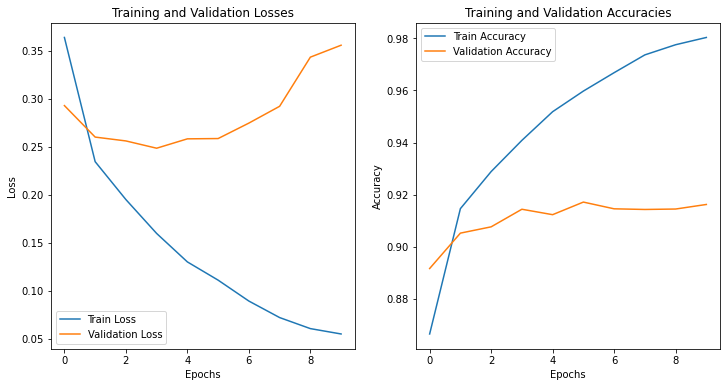

In [22]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#### Test Model

In [23]:
model.load_state_dict(torch.load(dir_path+"\\model\\saved_model.pth"))
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()

y_true, y_pred, test_loss, test_accuracy = evaluate_model(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2718
Test Accuracy: 0.9178


In [25]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.89      0.88      1000
           3       0.91      0.94      0.92      1000
           4       0.91      0.85      0.88      1000
           5       0.99      0.96      0.98      1000
           6       0.76      0.78      0.77      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



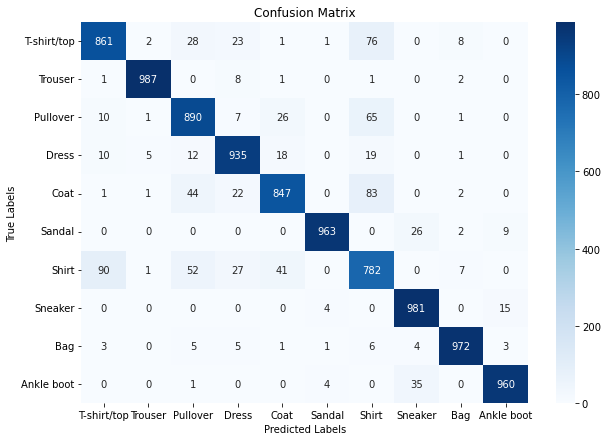

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(fashion_dict.values()), yticklabels=list(fashion_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

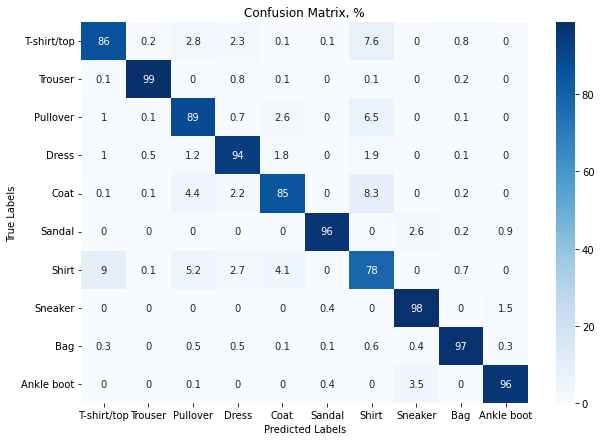

In [27]:
cm = confusion_matrix(y_true, y_pred, normalize='true')*100
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=list(fashion_dict.values()), yticklabels=list(fashion_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix, %')
plt.show()